# Imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import shap
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error 

import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import accuracy_score
import shap

warnings.filterwarnings('ignore')

c:\Users\USER\Desktop\Personal\Bits\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd


In [3]:
# Load your dataset
df = pd.read_csv("../../data/output.csv")

# Train & Test Split

The train.csv and test.csv files have been loaded successfully.


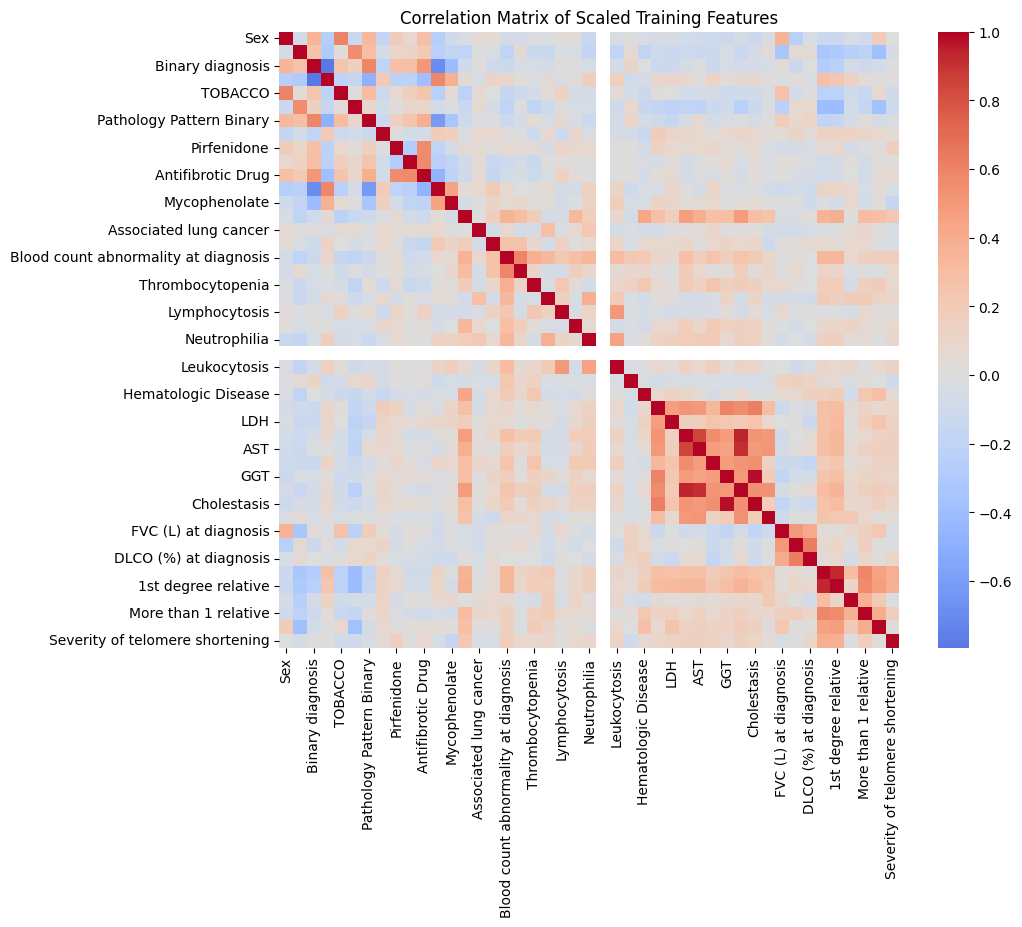

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Load the train and test datasets
train = pd.read_csv("../../data/train_0y.csv")
test = pd.read_csv("../../data/test_0y.csv")

# Separate features and the two target variables
X_train = train.drop(["Death", "Progressive disease"], axis=1)
y_train_death = train["Death"]
y_train_prog = train["Progressive disease"]


X_test = test.drop(["Death", "Progressive disease"], axis=1)
y_test_death = test["Death"]
y_test_prog = test["Progressive disease"]
print("The train.csv and test.csv files have been loaded successfully.")

# Optional: Scale the data if needed
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Plot correlation matrix to explore relationships
plt.figure(figsize=(10,8))
sns.heatmap(X_train_scaled_df.corr(), cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Scaled Training Features")
plt.show()


# Eda

## Missings

In [5]:
# Print how many missing values are in the dataset
print("The number of missing values in the dataset are:")
print(X_train.isnull().sum())
print(X_test.isnull().sum())

The number of missing values in the dataset are:
Sex                                     0
Age at diagnosis                        0
Binary diagnosis                        0
Final diagnosis                         0
TOBACCO                                 0
Comorbidities                           0
Pathology Pattern Binary                0
Multidsciplinary committee              0
Pirfenidone                             0
Nintedanib                              0
Antifibrotic Drug                       0
Prednisone                              0
Mycophenolate                           0
Extrapulmonary affectation              0
Associated lung cancer                  0
Other cancer                            0
Blood count abnormality at diagnosis    0
Anemia                                  0
Thrombocytopenia                        0
Thrombocytosis                          0
Lymphocytosis                           0
Lymphopenia                             0
Neutrophilia               

## Outliers

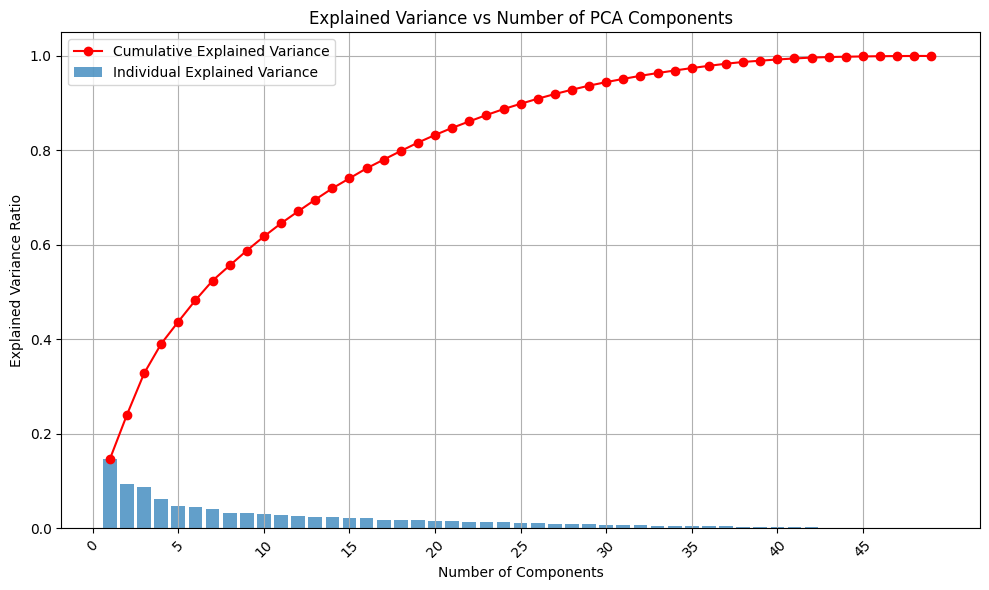

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Fit PCA
pca = PCA()
pca.fit(X_scaled)

explained_var_ratio = pca.explained_variance_ratio_
cumulative_var_ratio = np.cumsum(explained_var_ratio)

# Number of components
components = np.arange(1, len(explained_var_ratio) + 1)

plt.figure(figsize=(10, 6))

# Bar plot for individual explained variance
plt.bar(components, explained_var_ratio, alpha=0.7, label='Individual Explained Variance')

# Line plot for cumulative explained variance
plt.plot(components, cumulative_var_ratio, marker='o', color='red', label='Cumulative Explained Variance')

# Set labels and title
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance vs Number of PCA Components')

# Adjust ticks
# Show fewer ticks, for example every 5 components
plt.xticks(np.arange(0, len(components)+1, 5))
# Rotate tick labels if needed
plt.xticks(rotation=45)

plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [25]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest

# import tensorflow as tf
# from tensorflow.keras import layers, models # type: ignore
# import plotly.express as px

# Optional: Scale data for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# =================================
# Isolation Forest Outliers
# =================================
iso = IsolationForest(contamination='auto', random_state=42)
iso.fit(X_scaled)
iso_outliers = iso.predict(X_scaled)  # -1 for outliers, 1 for inliers
iso_outlier_mask = (iso_outliers == -1)

# =================================
# AutoEncoder Outliers
# =================================
input_dim = X_scaled.shape[1]

encoder = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(input_dim,)),
    layers.Dense(32, activation='relu')
])

decoder = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(32,)),
    layers.Dense(input_dim)
])

autoencoder = models.Sequential([encoder, decoder])
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(X_scaled, X_scaled, epochs=10, batch_size=32, validation_split=0.1, verbose=0)

reconstructions = autoencoder.predict(X_scaled)
errors = np.mean((X_scaled - reconstructions)**2, axis=1)

# Choose a threshold for outliers from AE
threshold = np.percentile(errors, 95)
ae_outlier_mask = (errors > threshold)

# =================================
# Dimensionality Reduction (PCA to 3D)
# =================================
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Convert to DataFrame for easy plotting
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3"])

# Add outlier info
df_pca['IF_Outlier'] = np.where(iso_outlier_mask, 'Outlier', 'Inlier')
df_pca['AE_Outlier'] = np.where(ae_outlier_mask, 'Outlier', 'Inlier')

# =================================
# Plotly Interactive Plots
# =================================

# Isolation Forest 3D Plot
fig_if = px.scatter_3d(
    df_pca, x='PC1', y='PC2', z='PC3',
    color='IF_Outlier',
    title="Isolation Forest Outliers",
    symbol='IF_Outlier',  # Using symbol can also differentiate outliers by shape
    hover_data=df_pca.columns
)
fig_if.show()

# AutoEncoder 3D Plot
fig_ae = px.scatter_3d(
    df_pca, x='PC1', y='PC2', z='PC3',
    color='AE_Outlier',
    title="AutoEncoder Outliers",
    symbol='AE_Outlier',
    hover_data=df_pca.columns
)
fig_ae.show()

ModuleNotFoundError: No module named 'tensorflow'

## Model

In [26]:
%%capture

import optuna
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def objective_death(trial):
    # Suggest a set of hyperparameters for this trial
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 15, 63),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0)
    }

    train_data_death = lgb.Dataset(X_train_scaled_df, label=y_train_death)
    valid_data_death = lgb.Dataset(X_test_scaled, label=y_test_death, reference=train_data_death)

    callbacks = [
        early_stopping(stopping_rounds=10),
        log_evaluation(period=0)  # silent
    ]

    model = lgb.train(
        param,
        train_data_death,
        valid_sets=[valid_data_death],
        num_boost_round=1000,
        callbacks=callbacks
    )

    y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
    score = accuracy_score(y_test_death, y_pred)
    return score

def objective_prog(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0)
    }

    train_data_prog = lgb.Dataset(X_train_scaled_df, label=y_train_prog)
    valid_data_prog = lgb.Dataset(X_test_scaled, label=y_test_prog, reference=train_data_prog)

    callbacks = [
        early_stopping(stopping_rounds=10),
        log_evaluation(period=0)  # silent
    ]

    model = lgb.train(
        param,
        train_data_prog,
        valid_sets=[valid_data_prog],
        num_boost_round=2000,
        callbacks=callbacks
    )

    y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
    score = accuracy_score(y_test_prog, y_pred)
    return score

# Optimize for "Death"
study_death = optuna.create_study(direction="maximize")
study_death.optimize(objective_death, n_trials=50)  # Increase for more exploration

# Train final model with best params for Death
best_params_death = study_death.best_params
best_params_death.update({'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt'})
train_data_death = lgb.Dataset(X_train_scaled_df, label=y_train_death)
valid_data_death = lgb.Dataset(X_test_scaled, label=y_test_death, reference=train_data_death)
model_death = lgb.train(
    best_params_death,
    train_data_death,
    valid_sets=[valid_data_death],
    num_boost_round=2000,
    callbacks=[early_stopping(10), log_evaluation(period=0)]
)
y_prob_death = model_death.predict(X_test_scaled)
y_pred_death = (y_prob_death > 0.5).astype(int)
acc_death = accuracy_score(y_test_death, y_pred_death)

# Optimize for "Progressive disease"
study_prog = optuna.create_study(direction="maximize")
study_prog.optimize(objective_prog, n_trials=50)  # Increase for more exploration

# Train final model with best params for Progressive disease
best_params_prog = study_prog.best_params
best_params_prog.update({'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt'})
train_data_prog = lgb.Dataset(X_train_scaled_df, label=y_train_prog)
valid_data_prog = lgb.Dataset(X_test_scaled, label=y_test_prog, reference=train_data_prog)
model_prog = lgb.train(
    best_params_prog,
    train_data_prog,
    valid_sets=[valid_data_prog],
    num_boost_round=2000,
    callbacks=[early_stopping(10), log_evaluation(period=0)]
)
y_prob_prog = model_prog.predict(X_test_scaled)
y_pred_prog = (y_prob_prog > 0.5).astype(int)
acc_prog = accuracy_score(y_test_prog, y_pred_prog)



In [30]:
print(acc_death, acc_prog)

0.8484848484848485 0.7878787878787878


In [37]:
# Show top 5 Trials for each study
print("Top 5 Trials for 'Death':")
df_death = study_death.trials_dataframe().sort_values("value", ascending=False)
print(df_death.head())

print("\nTop 5 Trials for 'Progressive disease':")
df_prog = study_prog.trials_dataframe().sort_values("value", ascending=False)
print(df_prog.head())

Top 5 Trials for 'Death':
    number     value             datetime_start          datetime_complete  \
16      16  0.848485 2024-12-14 22:31:02.318493 2024-12-14 22:31:02.373501   
23      23  0.848485 2024-12-14 22:31:02.744219 2024-12-14 22:31:02.804578   
35      35  0.848485 2024-12-14 22:31:03.455683 2024-12-14 22:31:03.514139   
39      39  0.848485 2024-12-14 22:31:03.712518 2024-12-14 22:31:03.768546   
26      26  0.848485 2024-12-14 22:31:02.939000 2024-12-14 22:31:02.996571   

                 duration  params_bagging_fraction  params_bagging_freq  \
16 0 days 00:00:00.055008                 0.939581                    5   
23 0 days 00:00:00.060359                 0.849280                    5   
35 0 days 00:00:00.058456                 0.665480                    4   
39 0 days 00:00:00.056028                 0.613139                    3   
26 0 days 00:00:00.057571                 0.789421                    3   

    params_feature_fraction  params_lambda_l1  params_

In [54]:
from sklearn.metrics import classification_report
# Train final model with best params for Death
best_params_death = study_death.best_params
best_params_death.update({'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt'})
train_data_death = lgb.Dataset(X_train_scaled_df, label=y_train_death)
valid_data_death = lgb.Dataset(X_test_scaled, label=y_test_death, reference=train_data_death)

model_death = lgb.train(
    best_params_death,
    train_data_death,
    valid_sets=[valid_data_death],
    num_boost_round=2000,
    callbacks=[early_stopping(10), log_evaluation(period=0)]
)


best_params_prog = study_prog.best_params
best_params_prog.update({'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt'})
train_data_prog = lgb.Dataset(X_train_scaled_df, label=y_train_prog)
valid_data_prog = lgb.Dataset(X_test_scaled, label=y_test_prog, reference=train_data_prog)

model_prog = lgb.train(
    best_params_prog,
    train_data_prog,
    valid_sets=[valid_data_prog],
    num_boost_round=2000,
    callbacks=[early_stopping(10), log_evaluation(period=0)]
)
# Save the "Death" model
model_prog.save_model("prog_model_y0.txt")
model_death.save_model("death_model_y0.txt")

y_prob_death = model_death.predict(X_test_scaled)
y_pred_death = (y_prob_death > 0.5).astype(int)
acc_death = accuracy_score(y_test_death, y_pred_death)

y_prob_prog = model_prog.predict(X_test_scaled)
y_pred_prog = (y_prob_prog > 0.5).astype(int)
acc_prog = accuracy_score(y_test_prog, y_pred_prog)
print(classification_report(y_test_death, y_pred_death))
print(acc_death, acc_prog)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 50, number of negative: 137
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 280
[LightGBM] [Info] Number of data points in the train set: 187, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267380 -> initscore=-1.007958
[LightGBM] [Info] Start training from score -1.007958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [33]:
print("Accuracy for 'Death':", acc_death)

Accuracy for 'Death': 0.8484848484848485


In [35]:
loaded_model_death = lgb.Booster(model_file="death_model_y0.txt")
# Use loaded_model_death.predict(...) as before



Epoch 152: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 157: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 198: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Final test accuracy for 'Death': 0.8181818181818182

Epoch 103: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 108: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 113: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Final test accuracy for 'Progressive disease': 0.8181818181818182


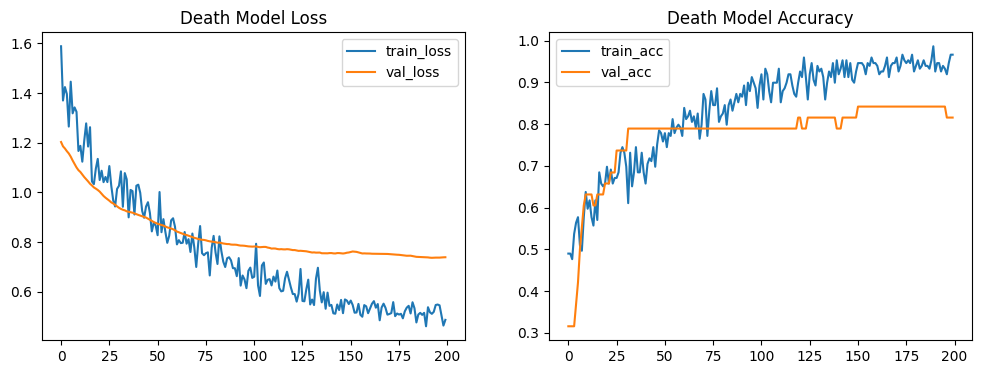

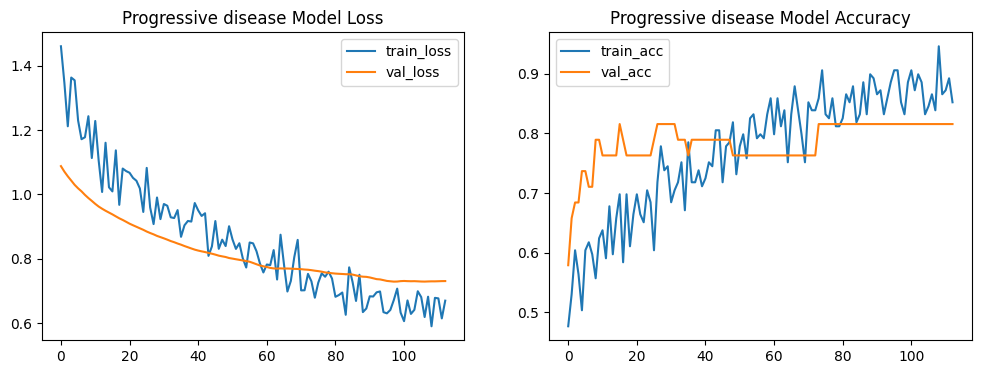

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Convert DataFrames/numpy arrays if needed
X_train = X_train_scaled_df.values  # Ensure this is a numpy array
X_test = X_test_scaled  # Already assumed to be numpy array

def build_complex_mlp(input_dim, l2_strength=0.002, dropout_rate=0.5):
    model = models.Sequential()
    # First layer
    model.add(layers.Dense(128, activation='relu', input_shape=(input_dim,),
                           kernel_regularizer=regularizers.l2(l2_strength)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))

    # Second layer
    model.add(layers.Dense(64, activation='relu',
                           kernel_regularizer=regularizers.l2(l2_strength)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))

    # Third layer
    model.add(layers.Dense(32, activation='relu',
                           kernel_regularizer=regularizers.l2(l2_strength)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    # Use a slightly lower learning rate for Adam, or try AdamW if available
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

input_dim = X_train.shape[1]

# Early stopping with increased patience
es = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Learning rate scheduler to reduce LR when no improvement in val_loss
rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# ===========================================
# Model for "Death"
# ===========================================
model_death = build_complex_mlp(input_dim, l2_strength=0.002, dropout_rate=0.5)

history_death = model_death.fit(
    X_train, y_train_death,
    validation_split=0.2,
    epochs=200,  # increased epochs for better exploration
    batch_size=32,
    callbacks=[es, rlr],
    verbose=0
)

# Evaluate on test
y_prob_death = model_death.predict(X_test)
y_pred_death = (y_prob_death > 0.5).astype(int)
acc_death = accuracy_score(y_test_death, y_pred_death)
print("Final test accuracy for 'Death':", acc_death)

# ===========================================
# Model for "Progressive disease"
# ===========================================
model_prog = build_complex_mlp(input_dim, l2_strength=0.002, dropout_rate=0.5)

history_prog = model_prog.fit(
    X_train, y_train_prog,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[es, rlr],
    verbose=0
)

# Evaluate on test
y_prob_prog = model_prog.predict(X_test)
y_pred_prog = (y_prob_prog > 0.5).astype(int)
acc_prog = accuracy_score(y_test_prog, y_pred_prog)
print("Final test accuracy for 'Progressive disease':", acc_prog)

# ===========================================
# Plotting Training Curves for Death
# ===========================================
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(history_death.history['loss'], label='train_loss')
axs[0].plot(history_death.history['val_loss'], label='val_loss')
axs[0].set_title('Death Model Loss')
axs[0].legend()

axs[1].plot(history_death.history['accuracy'], label='train_acc')
axs[1].plot(history_death.history['val_accuracy'], label='val_acc')
axs[1].set_title('Death Model Accuracy')
axs[1].legend()
plt.show()

# ===========================================
# Plotting Training Curves for Progressive Disease
# ===========================================
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(history_prog.history['loss'], label='train_loss')
axs[0].plot(history_prog.history['val_loss'], label='val_loss')
axs[0].set_title('Progressive disease Model Loss')
axs[0].legend()

axs[1].plot(history_prog.history['accuracy'], label='train_acc')
axs[1].plot(history_prog.history['val_accuracy'], label='val_acc')
axs[1].set_title('Progressive disease Model Accuracy')
axs[1].legend()
plt.show()
